In [1]:
###### import argparse
import os
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

import torch.nn.utils.spectral_norm as spectralnorm
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from models import *
from utils import *
from helper import *
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available else cpu)

!nvidia-smi

Tue Apr  9 14:53:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:86:00.0 Off |                    0 |
| N/A   38C    P8    16W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [57]:
def plot_R1_eps(x_1,x_2,x_1_hat,x_2_hat_JD, x_2_hat_NEW,x_2_hat_FMD, bitrate ,letter):
    fig, axarr = plt.subplots(4,2)
    fig.set_size_inches(10, 15)

    axarr[0,1].axis('off')
    axarr[0,0].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')
    axarr[2,0].axis('off')
    axarr[2,1].axis('off')
    axarr[3,0].axis('off')
    axarr[3,1].axis('off')


    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[1,0].set_title(r"$\hat{X}_1$ - 12 bits")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-JOINT$ - " + f'{bitrate} bits')
    axarr[2,0].set_title(r"$\hat{X}_1$  - 12 bits")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-FMD$ - "  + f'{bitrate} bits')
    axarr[3,0].set_title(r"$\hat{X}_1$  - 12 bits")
    axarr[3,1].set_title(r"$\hat{X}_2 ~ PLF-NEW$ - "  + f'{bitrate} bits')

    axarr[0,0].imshow(x_1.cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.cpu().data.numpy(),cmap = 'gray')
    axarr[1,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat_JD.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,1].imshow(x_2_hat_FMD.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,1].imshow(x_2_hat_NEW.squeeze().cpu().data.numpy(),cmap = 'gray')
    
    plt.imsave(f"./reconstructions/x1{letter}.png", x_1.cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x2{letter}.png", x_2.cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x1{letter}_hat_12.png",x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x2{letter}_JD_{bitrate}.png", x_2_hat_JD.squeeze().cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x2{letter}_FMD_{bitrate}.png", x_2_hat_FMD.squeeze().cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/x2{letter}_NEW_{bitrate}.png", x_2_hat_NEW.squeeze().cpu().data.numpy(),cmap = 'gray')
    

Finished Loading MNIST!
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


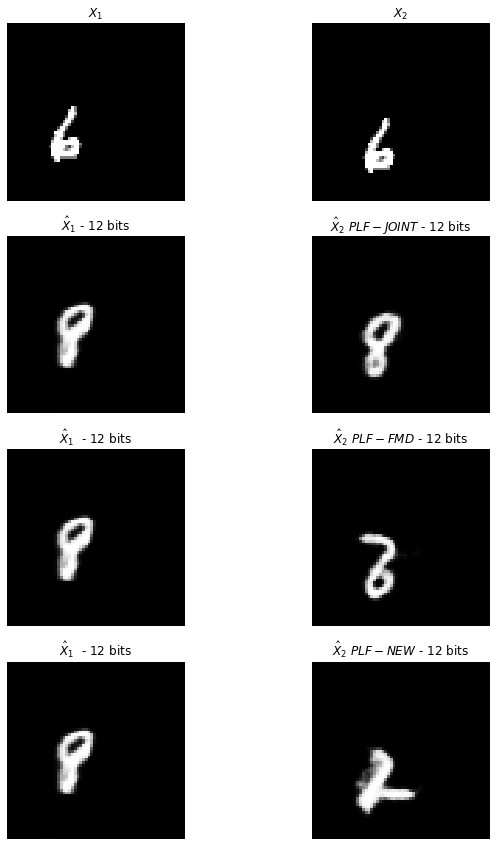

In [3]:
def R1_eps(z_dim =1,lambda_ = 0.0 , bitrate = 12, letter = 'a'):
    # path to load trained models from
    pre_path_NEW = f'./saved_models/R1-eps/{bitrate}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{lambda_}|lambdaMSE_1.0'
    

    pre_path_JD = f'./saved_models/R1-eps/{bitrate}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_{lambda_}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    
    pre_path_FMD = f'./saved_models/R1-eps/{bitrate}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'


    # load MMNIST
    train_loader, test_loader = get_dataloader(data_root='./data/', seq_len=8, batch_size=64, num_digits=1)

    # load fixed encoder for first frame
    device = torch.device('cuda' if torch.cuda.is_available else cpu)
    I_dim = 12 
    I_L = 2
    encoder = Encoder(dim=I_dim, nc=1, stochastic=True, quantize_latents=True, L=I_L).to(device).eval() 
    decoder = Decoder_Iframe(dim=I_dim).to(device).eval()
    decoder_hat = Decoder_Iframe(dim=I_dim).to(device).eval()
    encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
    decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
    decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))

    #load ssf models for second frame

    # NEW
    ssf_NEW = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_NEW.motion_encoder.load_state_dict(torch.load(pre_path_NEW+'/m_enc.pth'))
    ssf_NEW.motion_decoder.load_state_dict(torch.load(pre_path_NEW+'/m_dec.pth'))
    ssf_NEW.P_encoder.load_state_dict(torch.load(pre_path_NEW+'/p_enc.pth'))
    ssf_NEW.res_encoder.load_state_dict(torch.load(pre_path_NEW+'/r_enc.pth'))
    ssf_NEW.res_decoder.load_state_dict(torch.load(pre_path_NEW+'/r_dec.pth'))

    # JD
    ssf_JD = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_JD.motion_encoder.load_state_dict(torch.load(pre_path_JD+'/m_enc.pth'))
    ssf_JD.motion_decoder.load_state_dict(torch.load(pre_path_JD+'/m_dec.pth'))
    ssf_JD.P_encoder.load_state_dict(torch.load(pre_path_JD+'/p_enc.pth'))
    ssf_JD.res_encoder.load_state_dict(torch.load(pre_path_JD+'/r_enc.pth'))
    ssf_JD.res_decoder.load_state_dict(torch.load(pre_path_JD+'/r_dec.pth'))
    
    # FMD
    ssf_FMD = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_FMD.motion_encoder.load_state_dict(torch.load(pre_path_FMD+'/m_enc.pth'))
    ssf_FMD.motion_decoder.load_state_dict(torch.load(pre_path_FMD+'/m_dec.pth'))
    ssf_FMD.P_encoder.load_state_dict(torch.load(pre_path_FMD+'/p_enc.pth'))
    ssf_FMD.res_encoder.load_state_dict(torch.load(pre_path_FMD+'/r_enc.pth'))
    ssf_FMD.res_decoder.load_state_dict(torch.load(pre_path_FMD+'/r_dec.pth'))


    batch_index = torch.randint(64,(1,)).item()

    x = next(iter(test_loader))
    x = x.permute(0, 4, 1, 2, 3).to(device).float()

    # original frames
    x_1 = x[batch_index,0,0,:,:]
    x_2 = x[batch_index,0,1,:,:]

    hx = encoder(x[:,:,0,...])[0]
    x_ref = decoder(hx)
    print(x_ref.shape)
    print(x[:,:,0,...].shape)
    x_1_hat = decoder_hat(hx).detach()
    x_2_hat_JD = ssf_JD(x[:,:,1,...], x_ref, x_1_hat)
    x_2_hat_NEW = ssf_NEW(x[:,:,1,...], x_ref, x_1_hat)
    x_2_hat_FMD = ssf_FMD(x[:,:,1,...], x_ref, x_1_hat)

    plot_R1_eps(x_1, x_2,
                    x_1_hat[batch_index,0:,:], 
                    x_2_hat_JD[batch_index,0:,:], 
                    x_2_hat_NEW[batch_index,0:,:],
                    x_2_hat_FMD[batch_index,0:,:],
                   bitrate,
                   letter)


In [300]:
def plot_or_plf(x_1,x_2,x_1_hat,x_2_hat, eps, PLF,letter = 'a'):
    fig, axarr = plt.subplots(2,2)
    fig.set_size_inches(10, 10)

    axarr[0,1].axis('off')
    axarr[0,0].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')



    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[1,0].set_title(r"$\hat{X}_1$ - 12 bits")
    axarr[1,1].set_title(r"$\hat{X}_2 ~"+ f" PLF-{PLF} - " + f'{eps} bits')

    axarr[0,0].imshow(x_1.cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.cpu().data.numpy(),cmap = 'gray')
    axarr[1,0].imshow(x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat.squeeze().cpu().data.numpy(),cmap = 'gray')

    
    plt.imsave(f"./reconstructions/R1-eps/x1{letter}.png", x_1.cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/R1-eps/x2{letter}.png", x_2.cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/R1-eps/x1{letter}_hat_12.png",x_1_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    plt.imsave(f"./reconstructions/R1-eps/x2{letter}_{PLF}_{eps}.png", x_2_hat.squeeze().cpu().data.numpy(),cmap = 'gray')
    
    

def compare_or_plf(x, PLF = 'NEW', eps = 12, lambda_ = 0.01, gen_x_1_hat = True, x_1_hat = None, x_ref = None, letter = 'a'):
    # path to load trained models from
    z_dim = eps//2
    
    if PLF =='NEW':
        pre_path = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{lambda_}|lambdaMSE_1.0'
    elif PLF =='JD':
        pre_path = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                    + f'lambdaJD_{lambda_}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    elif PLF =='FMD':
        pre_path = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|'\
                + f'lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'

    # load fixed encoder for first frame
    device = torch.device('cuda' if torch.cuda.is_available else cpu)
    if gen_x_1_hat:
        I_dim = 12 
        I_L = 2
        encoder = Encoder(dim=I_dim, nc=1, stochastic=True, quantize_latents=True, L=I_L).to(device).eval() 
        decoder = Decoder_Iframe(dim=I_dim).to(device).eval()
        decoder_hat = Decoder_Iframe(dim=I_dim).to(device).eval()
        encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
        decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
        decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))

    #load ssf models for second frame

    # NEW
    ssf = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
    ssf.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
    ssf.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
    ssf.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
    ssf.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))

    # original frames
    x_1 = x[0,0,0,:,:]
    x_2 = x[0,0,1,:,:]
    if gen_x_1_hat:
        hx = encoder(x[:,:,0,...])[0]
        x_ref = decoder(hx)
        x_1_hat = decoder_hat(hx).detach()
    #print(x_ref.shape, x_1_hat.shape, x[:,:,1,...].shape)
    x_2_hat = ssf(x[:,:,1,...], x_ref, x_1_hat)
    
    
    
    x_1_hat_ = x_1_hat[0,0:,:]    
    x_2_hat = x_2_hat[0,0:,:]
    
    plot_or_plf(x_1,x_2,x_1_hat_,x_2_hat, eps, PLF,letter=letter)
    
    return x_1_hat, x_ref

    

Finished Loading MNIST!
[-1.0, 1.0]


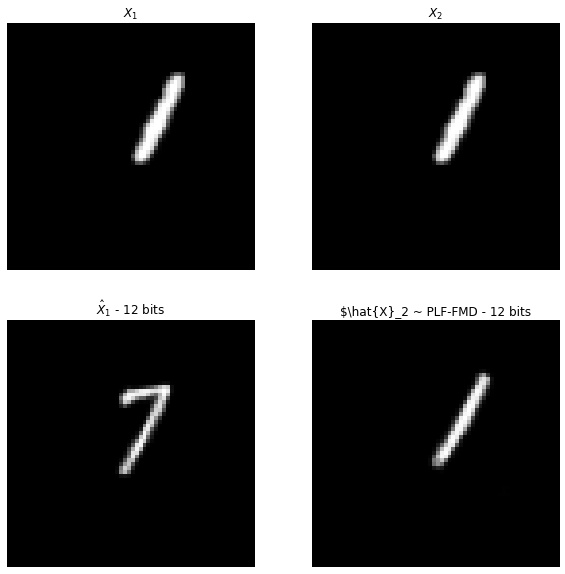

In [339]:
loader, _ = get_dataloader(data_root='./data/', dataset = 'mmnist', seq_len=3, batch_size=64, num_digits=1)
#x = next(iter(loader)).permute(0, 4, 1, 2, 3).to(device).float()
x1_hat, x_ref = compare_or_plf(x, PLF = 'FMD', eps = 12, lambda_ = 0.08, gen_x_1_hat = False, x_1_hat = x1_hat, x_ref = x_ref, letter = 'd')

In [105]:
def plot_img_series_2(x_1,x_2,x_2_hat_JD, x_2_hat_NEW,x_2_hat_FMD, bitrate):
    fig, axarr = plt.subplots(4,3)
    fig.set_size_inches(10, 15)

    axarr[0,0].axis('off')
    axarr[0,1].axis('off')
    axarr[0,2].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')
    axarr[1,2].axis('off')
    axarr[2,0].axis('off')
    axarr[2,1].axis('off')
    axarr[2,2].axis('off')
    axarr[3,0].axis('off')
    axarr[3,1].axis('off')
    axarr[3,2].axis('off')


    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[0,2].set_title("original trajectory")
    axarr[1,0].set_title(r"$X_1$ ")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-JD$ - " + f'{bitrate} bits')
    axarr[1,2].set_title("JD trajectory")
    axarr[2,0].set_title(r"$X_1$")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-FMD$ - "  + f'{bitrate} bits')
    axarr[2,2].set_title("FMD trajectory")
    axarr[3,0].set_title(r"$X_1$")
    axarr[3,1].set_title(r"$\hat{X}_2 ~ PLF-NEW$ - "  + f'{bitrate} bits')
    axarr[3,2].set_title("NEW trajectory")

    or_t = x_1.squeeze().cpu().data.numpy() + x_2.squeeze().cpu().data.numpy()
    jd_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD.squeeze().cpu().data.numpy()
    fmd_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_FMD.squeeze().cpu().data.numpy()
    new_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_NEW.squeeze().cpu().data.numpy()
    
    or_t[or_t>1] = 1
    jd_t[jd_t>1] = 1
    fmd_t[fmd_t>1] = 1
    new_t[new_t>1] = 1
    
    axarr[0,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,2].imshow(or_t, cmap = 'gray')
    
    axarr[1,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat_JD.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,2].imshow(jd_t, cmap = 'gray')
    
    axarr[2,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,1].imshow(x_2_hat_FMD.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,2].imshow(fmd_t, cmap = 'gray')
    
    axarr[3,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,1].imshow(x_2_hat_NEW.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,2].imshow(new_t, cmap = 'gray')
    

In [44]:
def plot_inf_eps_JD(x_1,x_2,x_2_hat_JD1, x_2_hat_JD2,x_2_hat_JD3, bitrate):
    fig, axarr = plt.subplots(4,3)
    fig.set_size_inches(10, 15)
    zeros = torch.zeros_like(x_1)
    for i in range(4):
        for j in range(3):
            axarr[i,j].axis('off')

    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[0,2].set_title("original trajectory")
    axarr[1,0].set_title(r"$X_1$ ")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-JD 1$ - " + f'{bitrate} bits')
    axarr[1,2].set_title("JD trajectory 1")
    axarr[2,0].set_title(r"$X_1$")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-JD 2$ - "  + f'{bitrate} bits')
    axarr[2,2].set_title("JD trajectory 2")
    axarr[3,0].set_title(r"$X_1$")
    axarr[3,1].set_title(r"$\hat{X}_2 ~ PLF-JD 3$ - "  + f'{bitrate} bits')
    axarr[3,2].set_title("JD trajectory 3")
    
    or_t = torch.cat((x_1, x_2, zeros ), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    jd_t1 = torch.cat((x_1, x_2_hat_JD1, zeros ), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    jd_t2 = torch.cat((x_1, x_2_hat_JD2, zeros ), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    jd_t3 = torch.cat((x_1, x_2_hat_JD3, zeros ), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    axarr[0,0].imshow(torch.cat((x_1, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[0,1].imshow(torch.cat((zeros, x_2, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[0,2].imshow(or_t)
    
    axarr[1,0].imshow(torch.cat((x_1, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[1,1].imshow(torch.cat((zeros, x_2_hat_JD1, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[1,2].imshow(jd_t1)
    
    axarr[2,0].imshow(torch.cat((x_1, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[2,1].imshow(torch.cat((zeros, x_2_hat_JD2, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[2,2].imshow(jd_t2)
    
    axarr[3,0].imshow(torch.cat((x_1, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[3,1].imshow(torch.cat((zeros, x_2_hat_JD3, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[3,2].imshow(jd_t3)



def inf_eps_JD(lambda_ = 0.0 , eps = 2, x = 0, step =5, dataset = 'mmnist_unidir_4_axis_centered'):
    # path to load trained models from
    pre_path_JD = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_{lambda_}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    z_dim = eps//2
    #load ssf models for second frame
    
    
    # JD
    ssf_JD = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_JD.motion_encoder.load_state_dict(torch.load(pre_path_JD+'/m_enc.pth'))
    ssf_JD.motion_decoder.load_state_dict(torch.load(pre_path_JD+'/m_dec.pth'))
    ssf_JD.P_encoder.load_state_dict(torch.load(pre_path_JD+'/p_enc.pth'))
    ssf_JD.res_encoder.load_state_dict(torch.load(pre_path_JD+'/r_enc.pth'))
    ssf_JD.res_decoder.load_state_dict(torch.load(pre_path_JD+'/r_dec.pth'))
    
    # original frames
    x_1 = x[:,:,0,...]
    x_2 = x[:,:,1,...]
    x_2_hat_JD1 = ssf_JD(x_2,x_1)
    x_2_hat_JD2 = ssf_JD(x_2,x_1)
    x_2_hat_JD3 = ssf_JD(x_2,x_1)

    plot_inf_eps_JD(x_1[0],
                      x_2[0], 
                    x_2_hat_JD1[0,0:,:], 
                    x_2_hat_JD2[0,0:,:],
                    x_2_hat_JD3[0,0:,:],
                   eps)

Finished Loading MovingMNIST_unidir_4_axis_random_sample_step!
[-1.0, 1.0]


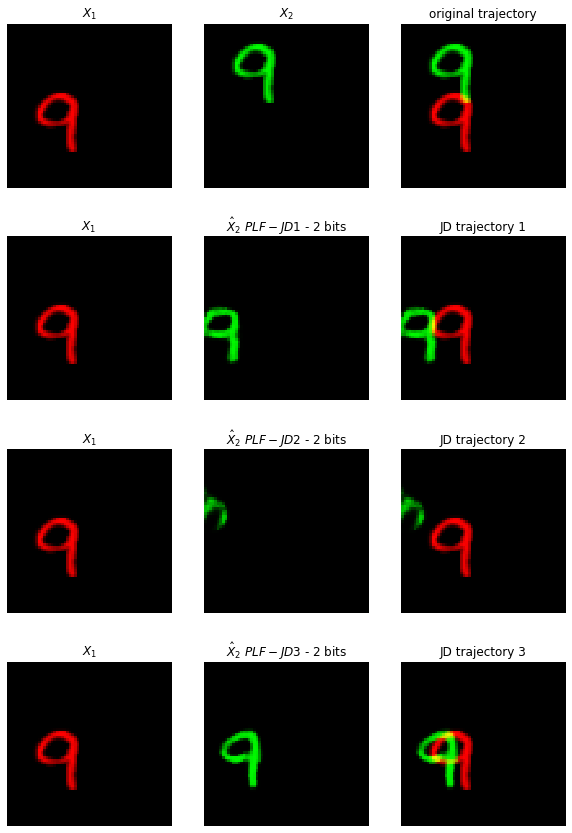

In [49]:
dataset = 'mmnist_4_axis_random_sample_step'
step = 20
loader, _ = get_dataloader(data_root='./data/', dataset = dataset, seq_len=3, batch_size=64, num_digits=1, step = step)
x = next(iter(loader)).permute(0, 4, 1, 2, 3).to(device).float()
inf_eps_JD(lambda_ = 0.03 , eps = 2, x = x, step =20, dataset = dataset)

In [18]:
def plot_img_series_FMD(x_1,x_2,x_2_hat_JD1, x_2_hat_JD2,x_2_hat_JD3, bitrate):
    fig, axarr = plt.subplots(4,3)
    fig.set_size_inches(10, 15)

    axarr[0,0].axis('off')
    axarr[0,1].axis('off')
    axarr[0,2].axis('off')
    axarr[1,0].axis('off')
    axarr[1,1].axis('off')
    axarr[1,2].axis('off')
    axarr[2,0].axis('off')
    axarr[2,1].axis('off')
    axarr[2,2].axis('off')
    axarr[3,0].axis('off')
    axarr[3,1].axis('off')
    axarr[3,2].axis('off')


    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[0,2].set_title("original trajectory")
    axarr[1,0].set_title(r"$X_1$ ")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-FMD 1$ - " + f'{bitrate} bits')
    axarr[1,2].set_title("JD trajectory 1")
    axarr[2,0].set_title(r"$X_1$")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-FMD 2$ - "  + f'{bitrate} bits')
    axarr[2,2].set_title("JD trajectory 2")
    axarr[3,0].set_title(r"$X_1$")
    axarr[3,1].set_title(r"$\hat{X}_2 ~ PLF-FMD 3$ - "  + f'{bitrate} bits')
    axarr[3,2].set_title("JD trajectory 3")

    or_t = x_1.squeeze().cpu().data.numpy() + x_2.squeeze().cpu().data.numpy()
    jd1_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD1.squeeze().cpu().data.numpy()
    jd2_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD2.squeeze().cpu().data.numpy()
    jd3_t = x_1.squeeze().cpu().data.numpy() + x_2_hat_JD3.squeeze().cpu().data.numpy()
    
    or_t[or_t>1] = 1
    jd1_t[jd1_t>1] = 1
    jd2_t[jd2_t>1] = 1
    jd3_t[jd3_t>1] = 1
    
    axarr[0,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,1].imshow(x_2.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[0,2].imshow(or_t, cmap = 'gray')
    
    axarr[1,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,1].imshow(x_2_hat_JD1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[1,2].imshow(jd1_t, cmap = 'gray')
    
    axarr[2,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,1].imshow(x_2_hat_JD2.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[2,2].imshow(jd2_t, cmap = 'gray')
    
    axarr[3,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,1].imshow(x_2_hat_JD3.squeeze().cpu().data.numpy(),cmap = 'gray')
    axarr[3,2].imshow(jd3_t, cmap = 'gray')



def compare_models_FMD(lambda_ = 0.0 , eps = 2, x = 0, step =5):
    # path to load trained models from
    pre_path_FMD = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'
    z_dim = eps//2
    #load ssf models for second frame
    
    
    # JD
    ssf_FMD = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_FMD.motion_encoder.load_state_dict(torch.load(pre_path_FMD+'/m_enc.pth'))
    ssf_FMD.motion_decoder.load_state_dict(torch.load(pre_path_FMD+'/m_dec.pth'))
    ssf_FMD.P_encoder.load_state_dict(torch.load(pre_path_FMD+'/p_enc.pth'))
    ssf_FMD.res_encoder.load_state_dict(torch.load(pre_path_FMD+'/r_enc.pth'))
    ssf_FMD.res_decoder.load_state_dict(torch.load(pre_path_FMD+'/r_dec.pth'))
    
    # original frames
    x_1 = x[:,:,0,...]
    x_2 = x[:,:,1,...]
    x_2_hat_FMD1 = ssf_FMD(x_2,x_1)
    x_2_hat_FMD2 = ssf_FMD(x_2,x_1)
    x_2_hat_FMD3 = ssf_FMD(x_2,x_1)

    plot_img_series_FMD(x_1[0],
                      x_2[0], 
                    x_2_hat_FMD1[0,0:,:], 
                    x_2_hat_FMD2[0,0:,:],
                    x_2_hat_FMD3[0,0:,:],
                   eps)

In [232]:
def compare_models_2(lambda_ = 0.0 , eps = 2, x = 0,step=15, stochastic = True):
    # path to load trained models from
    pre_path_NEW = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{lambda_}|lambdaMSE_1.0'
    pre_path_JD = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_{lambda_}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    pre_path_FMD = f'./saved_models/inf-eps/step_{step}/inf-{eps}|lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'
    z_dim = eps//2
    #load ssf models for second frame
    
    # NEW
    ssf_NEW = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=stochastic, quantize_latents=True, L=2).to(device).eval()
    ssf_NEW.motion_encoder.load_state_dict(torch.load(pre_path_NEW+'/m_enc.pth'))
    ssf_NEW.motion_decoder.load_state_dict(torch.load(pre_path_NEW+'/m_dec.pth'))
    ssf_NEW.P_encoder.load_state_dict(torch.load(pre_path_NEW+'/p_enc.pth'))
    ssf_NEW.res_encoder.load_state_dict(torch.load(pre_path_NEW+'/r_enc.pth'))
    ssf_NEW.res_decoder.load_state_dict(torch.load(pre_path_NEW+'/r_dec.pth'))

    # JD
    ssf_JD = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_JD.motion_encoder.load_state_dict(torch.load(pre_path_JD+'/m_enc.pth'))
    ssf_JD.motion_decoder.load_state_dict(torch.load(pre_path_JD+'/m_dec.pth'))
    ssf_JD.P_encoder.load_state_dict(torch.load(pre_path_JD+'/p_enc.pth'))
    ssf_JD.res_encoder.load_state_dict(torch.load(pre_path_JD+'/r_enc.pth'))
    ssf_JD.res_decoder.load_state_dict(torch.load(pre_path_JD+'/r_dec.pth'))
    
    # FMD
    ssf_FMD = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=stochastic, quantize_latents=True, L=2).to(device).eval()
    ssf_FMD.motion_encoder.load_state_dict(torch.load(pre_path_FMD+'/m_enc.pth'))
    ssf_FMD.motion_decoder.load_state_dict(torch.load(pre_path_FMD+'/m_dec.pth'))
    ssf_FMD.P_encoder.load_state_dict(torch.load(pre_path_FMD+'/p_enc.pth'))
    ssf_FMD.res_encoder.load_state_dict(torch.load(pre_path_FMD+'/r_enc.pth'))
    ssf_FMD.res_decoder.load_state_dict(torch.load(pre_path_FMD+'/r_dec.pth'))

    # original frames
    x_1 = x[:,:,0,...]
    x_2 = x[:,:,1,...]
    x_2_hat_JD = ssf_JD(x_2,x_1)
    x_2_hat_NEW = ssf_NEW(x_2,x_1)
    x_2_hat_FMD = ssf_FMD(x_2,x_1)

    plot_img_series_2(x_1[0],
                      x_2[0], 
                    x_2_hat_JD[0,0:,:], 
                    x_2_hat_NEW[0,0:,:],
                    x_2_hat_FMD[0,0:,:],
                   eps)


Finished Loading MNIST!
torch.Size([64, 1, 8, 64, 64])


In [17]:
def load_ssf_model(model, pre_path):
    model.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
    model.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
    model.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
    model.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
    model.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))
    return model

In [33]:
def plot_inf_eps1_eps2(x_0, x_1,x_2, x_1_hat_JD,x_1_hat_NEW, x_2_hat_JD, x_2_hat_NEW, eps1, eps2):
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(15, 10)
    zeros = torch.zeros_like(x_0)
    
    for i in range(3):
        for j in range(4):
            axarr[i,j].axis('off')

    axarr[0,0].set_title(r"$X_1$")
    axarr[0,1].set_title(r"$X_2$")
    axarr[0,2].set_title(r"$X_3$")
    axarr[0,3].set_title("original trajectory")
    
    axarr[1,0].set_title(r"$X_1$ ")
    axarr[1,1].set_title(r"$\hat{X}_2 ~ PLF-JD$ - " + f'{eps1} bits')
    axarr[1,2].set_title(r"$\hat{X}_3 ~ PLF-JD$ - " + f'{eps2} bits')
    axarr[1,3].set_title("JD trajectory")
    
    #axarr[2,0].set_title(r"$X_1$")
    #axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-FMD$ - "  + f'{bitrate} bits')
    #axarr[2,2].set_title("FMD trajectory")
    
    axarr[2,0].set_title(r"$X_1$")
    axarr[2,1].set_title(r"$\hat{X}_2 ~ PLF-NEW$ - "  + f'{eps1} bits')
    axarr[2,2].set_title(r"$\hat{X}_3 ~ PLF-NEW$ - " + f'{eps2} bits')  
    axarr[2,3].set_title("NEW trajectory")

    or_t = torch.cat((x_0, x_1, x_2), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    jd_t = torch.cat((x_0, x_1_hat_JD, x_2_hat_JD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    new_t = torch.cat((x_0, x_1_hat_NEW, x_2_hat_NEW), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    #fmd_t = 
    or_t = torch.cat((x_0, x_1, x_2), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()

    axarr[0,0].imshow(torch.cat((x_0, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[0,1].imshow(torch.cat((zeros,x_1, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[0,2].imshow(torch.cat((zeros,zeros, x_2), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[0,3].imshow(or_t)
    
    axarr[1,0].imshow(torch.cat((x_0, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[1,1].imshow(torch.cat((zeros,x_1_hat_JD, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[1,2].imshow(torch.cat((zeros,zeros, x_2_hat_JD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[1,3].imshow(jd_t)
    
    #axarr[2,0].imshow(x_1.squeeze().cpu().data.numpy(),cmap = 'gray')
    #axarr[2,1].imshow(x_2_hat_FMD.squeeze().cpu().data.numpy(),cmap = 'gray')
    #axarr[2,2].imshow(fmd_t, cmap = 'gray')
    
    axarr[2,0].imshow(torch.cat((x_0, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[2,1].imshow(torch.cat((zeros,x_1_hat_NEW, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[2,2].imshow(torch.cat((zeros,zeros, x_2_hat_NEW), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
    axarr[2,3].imshow(new_t)
    
def inf_eps1_eps2(l_JD1 = 0.0, l_JD2=0, l_NEW2=0 , eps1 = 2,eps2 =8, x = 0,step=15, stochastic = True, save = False):
    # set paths
    pre_path_JD1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_{l_JD1}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    #pre_path_FMD1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'
    pre_path_JD2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_{l_JD2}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    pre_path_NEW2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{l_NEW2}|lambdaMSE_1.0'
    #pre_path_FMD2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|lambdaFMD_{lambda_}|lambdaNEW_0.0|lambdaMSE_1.0'
    
    zdim_1 = eps1//2
    zdim_2 = eps2//2
    
    #load models for second frame
    ssf_JD1 = ScaleSpaceFlow(num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2).to(device).eval()
    ssf_JD1 = load_ssf_model(ssf_JD1, pre_path_JD1)
    #ssf_FMD = ScaleSpaceFlow(num_levels=1, dim=z_dim, stochastic=stochastic, quantize_latents=True, L=2).to(device).eval()
    #ssf_FMD = load_ssf_model(ssf_JD, pre_path_JD)
    
    #load models for third frame 
    ssf_JD2 = ScaleSpaceFlow_R1eps_e2e_3frames(num_levels=1, dim=zdim_2, stochastic=True,\
                                               quantize_latents=True, L=2, single_bit=False,num_c=1,\
                                               activation=torch.sigmoid).to(device)
    ssf_NEW2 = ScaleSpaceFlow_R1eps_e2e_3frames(num_levels=1, dim=zdim_2, stochastic=True,\
                                               quantize_latents=True, L=2, single_bit=False,num_c=1,\
                                               activation=torch.sigmoid).to(device)
    #ssf_FMD2 = ScaleSpaceFlow_R1eps_e2e_3frames(num_levels=1, dim=zdim_2, stochastic=True,quantize_latents=True, L=L, single_bit=single_bit,num_c=1,activation=torch.sigmoid).to(device)
    ssf_JD2 = load_ssf_model(ssf_JD2, pre_path_JD2)
    ssf_NEW2 = load_ssf_model(ssf_JD2, pre_path_NEW2)
    #ssf_FMD2 = load_ssf_model(ssf_FMD2, pre_path_FMD2)
    
    # original frames
    x_0 = x[:,:,0,...]
    x_1 = x[:,:,1,...]
    x_2 = x[:,:,2,...]
    x1_hat_JD = ssf_JD1(x_1, x_0)
    x1_hat_NEW = ssf_JD1(x_1, x_0)
    #x_2_hat_FMD = ssf_FMD(x_2,x_1)
    x2_hat_JD = ssf_JD2(x_2, x1_hat_JD, x_0, x1_hat_JD)
    x2_hat_NEW = ssf_NEW2(x_2, x1_hat_NEW, x_0, x1_hat_NEW)
    #x2_hat_FMD = ssf_NEW2(x_2, x1_hat_JD, x_0, x1_hat_JD)
    
    
    plot_inf_eps1_eps2(x_0[0], x_1[0],x_2[0],
                       x1_hat_JD[0,0:,:],
                       x1_hat_NEW[0,0:,:],
                       x2_hat_JD[0,0:,:],
                       x2_hat_NEW[0,0:,:],
                       eps1, eps2)

In [34]:
loader, _ = get_dataloader(data_root='./data/', dataset = 'mmnist_unidir', seq_len=3, batch_size=64, num_digits=1)
#x = next(iter(loader)).permute(0, 4, 1, 2, 3).to(device).float()
inf_eps1_eps2(l_JD1 = 0.08, l_JD2 = 0.06,l_NEW2 = 0.08 , eps1 = 2, eps2 =8, x=x, step=15)

NameError: name 'MovingMNIST_unidir' is not defined

In [31]:
def plot_batch_seq(seq_len,bs, dataset, step = [15,10]):
    loader, _ = get_dataloader(data_root='./data/', dataset = dataset, seq_len=seq_len, batch_size=bs, num_digits=1, step = step)
    x = next(iter(loader)).permute(0, 4, 1, 2, 3).to(device).float()
    fig, axarr = plt.subplots(bs,seq_len+1)
    fig.set_size_inches(4*(seq_len+1), 4* bs)
    zeros = torch.zeros_like(x[0,:,0,...])
    for i in range(x.shape[0]):
        for j in range(seq_len+1):
            axarr[i,j].axis('off') 
        axarr[i,0].imshow(torch.cat((x[i,:,0,...], zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
        axarr[i,1].imshow(torch.cat((zeros,x[i,:,1,...], zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
        axarr[i,2].imshow(torch.cat((zeros,zeros, x[i,:,2,...]), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())
        axarr[i,3].imshow(torch.cat((x[i,:,0,...], x[i,:,1,...], x[i,:,2,...]), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy())

Finished Loading MovingMNIST_unidir_4_axis_random_sample_step!


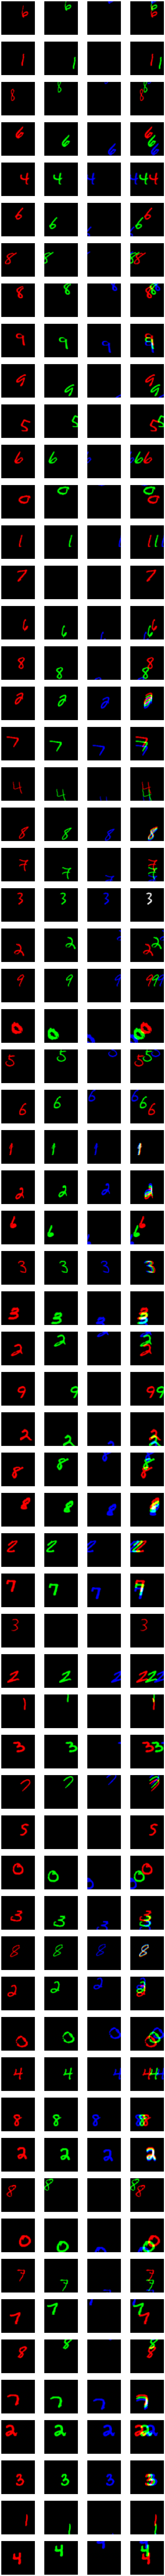

In [32]:
plot_batch_seq(3,64, 'mmnist_4_axis_random_sample_step',step = 20)

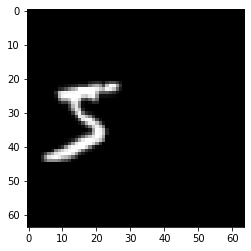

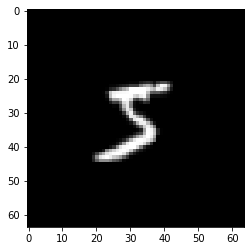

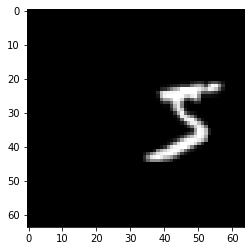

In [6]:

data = datasets.MNIST( './data',train=True, download=True,transform=transforms.Compose([transforms.Resize(32),transforms.ToTensor()]))
x = np.zeros((3,64,64,1), dtype=np.float32)
digit, _ =data[0]
sy = 16
sx = 0
x[0, sy:sy+32, sx:sx+32, 0] = digit.numpy().squeeze()
plt.imshow(x[0,:,:,0], cmap = 'gray')
plt.show()
x[1,:,:,0] = np.roll(x[0, :, :, 0], 15, axis = 1)
plt.imshow(x[1,:,:,0], cmap = 'gray')
plt.show()
x[2,:,:,0] = np.roll(x[1, :, :, 0], 15, axis = 1)
plt.imshow(x[2,:,:,0], cmap = 'gray')
plt.show()

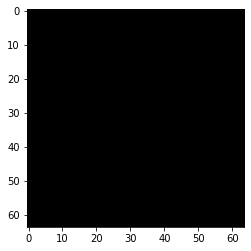

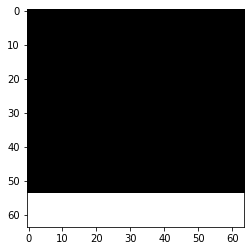

In [4]:
a = np.zeros((64,64))
plt.imshow(a,cmap = 'gray')
plt.show()
a[-10:,:] = 1
plt.imshow(a,cmap = 'gray')
plt.show()